In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.getcwd(), 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features import process_features
from features.process_features import get_vif, standardize
from features.process_features import RIAU_BASIC_FEATURES

ALGORITHM_NAME = 'rf'
COUNTRY = 'riau'
TRAIN_PATH, TEST_PATH = get_country_filepaths(COUNTRY)

In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.miskin.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 6,136 rows and 506 columns
Percent poor: 4.9% 	Percent non-poor: 95.1%


,r105,r1701,r1702,r1703,r1704,r1705,r1706,r1707,r1708,r1801,...,kons_307,kons_308,kons_309,kons_310,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nbekerja,der_ninternetpast3mo
0,1,5,5,5,5,5,5,5,5,0,...,0,0,0,0,0,0,1,1,0,1
1,2,5,5,5,5,5,5,5,5,1,...,0,0,0,0,0,3,1,4,1,2
2,1,5,5,5,5,5,5,5,5,1,...,0,0,0,0,0,3,2,5,1,5
3,2,5,5,5,5,5,5,5,5,1,...,0,0,0,0,1,3,2,5,2,1
4,2,5,5,5,5,5,5,5,5,1,...,0,0,0,0,0,1,1,2,1,0


## Random forest with simple features 

We'll start with the simple set of features stored in RIAU_BASIC_FEATURES in the process_features module.

In [3]:
# Select the basic features we've used previously
selected_columns = RIAU_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (6136, 10)


In [4]:
# Create DataFrame of feature importances
def get_feat_imp_df(feat_imps, index=None, sort=True):
    feat_imps = pd.DataFrame(feat_imps, columns=['importance'])
    if index is not None:
        feat_imps.index = index
    if sort:
        feat_imps = feat_imps.sort_values('importance', ascending=False)
    return feat_imps

Wall time: 330 ms
Wall time: 91 ms
In-sample score: 96.99%


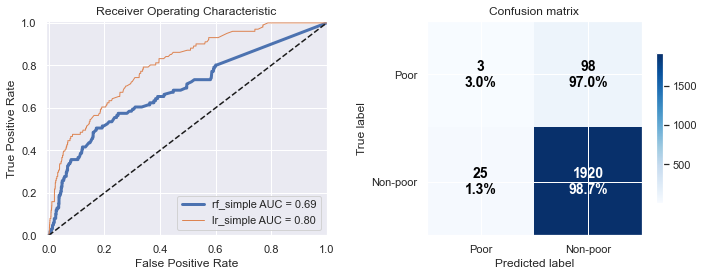

,rf_simple,lr_simple
accuracy,0.939883,0.950147
recall,0.029703,0.009901
precision,0.107143,0.333333
f1,0.046512,0.019231
cross_entropy,0.492030,0.164615
roc_auc,0.685294,0.799743
cohen_kappa,0.025631,0.016430


Actual poverty rate: 6.82% 
Predicted poverty rate: 3.16% 


In [5]:
from sklearn.ensemble import RandomForestClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

# Fit the model
model = RandomForestClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

In [6]:
feat_imps

,importance
der_nbekerja,0.175885
der_nliterate,0.161012
r1816,0.132766
r301,0.132566
der_nchild10under,0.115980
der_nmalesover10,0.093693
r1809a,0.086772
der_nfemalesover10,0.084614
kons_305,0.008983
kons_262,0.007727


## Random forest with all features 
Now let's apply the Random Forest classifier to the dataset with all features.

Wall time: 1.23 s
Wall time: 111 ms
In-sample score: 100.00%


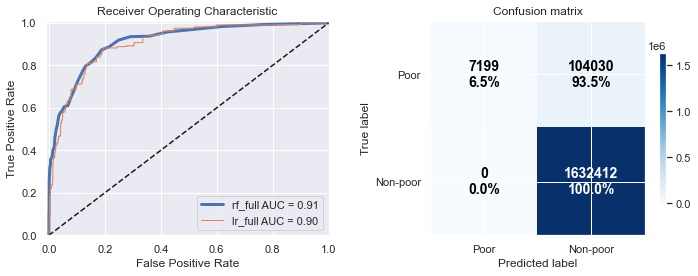

,rf_full,lr_full
accuracy,0.940338,0.930738
recall,0.064722,0.466875
precision,1.000000,0.457938
f1,0.121576,0.462363
cross_entropy,0.167726,1.327124
roc_auc,0.912237,0.904081
cohen_kappa,0.072703,0.363980


Actual poverty rate: 6.82% 
Predicted poverty rate: 5.35% 


In [7]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = RandomForestClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

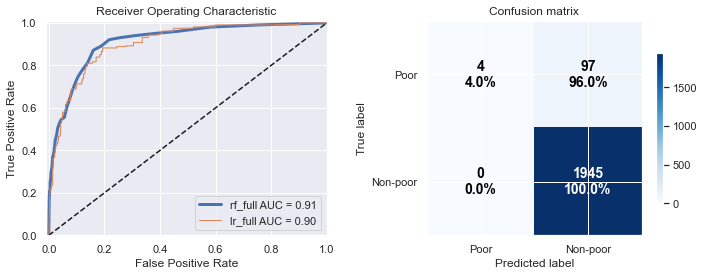

,rf_full,lr_full
accuracy,0.952590,0.930738
recall,0.039604,0.466875
precision,1.000000,0.457938
f1,0.076190,0.462363
cross_entropy,0.145552,1.327124
roc_auc,0.913816,0.904081
cohen_kappa,0.072703,0.363980


Actual poverty rate: 6.82% 
Predicted poverty rate: 5.35% 


In [8]:
# Evaluate performance and store model without w_test
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

In [9]:
feat_imps

,importance
r301,0.029641
der_nchild10under,0.023134
r303,0.019257
r1804,0.018273
der_ninternetpast3mo,0.015831
...,...
kons_15,0.000000
r1901c,0.000000
kons_54,0.000000
kons_218,0.000000


## Class Weighting
The random forest classifier includes the option to balance the classes with class_weight='balanced', so we'll first try this before applying a sampling method. We'll also pick a few parameters to reduce overfitting.

Wall time: 1.17 s
Wall time: 129 ms
In-sample score: 99.71%


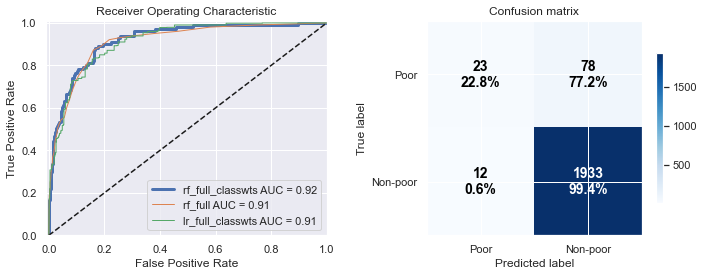

,rf_full_classwts,rf_full,lr_full_classwts
accuracy,0.956012,0.952590,0.929499
recall,0.227723,0.039604,0.479928
precision,0.657143,1.000000,0.450620
f1,0.338235,0.076190,0.464812
cross_entropy,0.172160,0.145552,1.082523
roc_auc,0.921143,0.913816,0.914168
cohen_kappa,0.320983,0.072703,0.400154


Actual poverty rate: 6.82% 
Predicted poverty rate: 6.07% 


In [10]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = RandomForestClassifier(n_estimators=100, 
                               max_depth=20, 
                               min_samples_leaf=5, 
                               min_samples_split=5, 
                               class_weight='balanced')
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    compare_models=['rf_full', 
                                                    'lr_full_classwts'],
                                    store_model=True,
                                    model_name='full_classwts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

## Undersampling
Now we'll apply undersampling and see how the performance is affected.

X shape after undersampling:  (602, 506)
Wall time: 208 ms
Wall time: 30 ms
In-sample score: 96.18%
Wall time: 53 ms
Wall time: 40 ms


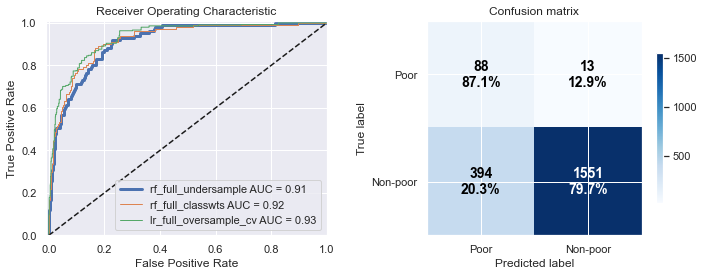

,rf_full_undersample,rf_full_classwts,lr_full_oversample_cv
accuracy,0.801075,0.956012,0.940535
recall,0.871287,0.227723,0.682982
precision,0.182573,0.657143,0.526119
f1,0.301887,0.338235,0.594375
cross_entropy,0.449701,0.172160,0.282615
roc_auc,0.913039,0.921143,0.932446
cohen_kappa,0.239838,0.320983,0.501967


Actual poverty rate: 6.82% 
Predicted poverty rate: 25.53% 


In [12]:
from imblearn.under_sampling import RandomUnderSampler

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = RandomForestClassifier(n_estimators=100, 
                               max_depth=20, 
                               min_samples_leaf=5, 
                               min_samples_split=5)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    compare_models=['rf_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)

## Oversampling

X shape after oversampling:  (11670, 506)
Wall time: 3.85 s
Wall time: 216 ms
In-sample score: 99.02%
Wall time: 59 ms
Wall time: 44 ms


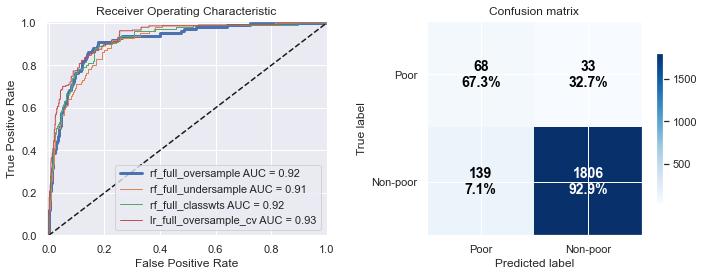

,rf_full_oversample,rf_full_undersample,rf_full_classwts,lr_full_oversample_cv
accuracy,0.915934,0.801075,0.956012,0.940535
recall,0.673267,0.871287,0.227723,0.682982
precision,0.328502,0.182573,0.657143,0.526119
f1,0.441558,0.301887,0.338235,0.594375
cross_entropy,0.378935,0.449701,0.172160,0.282615
roc_auc,0.917188,0.913039,0.921143,0.932446
cohen_kappa,0.401870,0.239838,0.320983,0.501967


Actual poverty rate: 6.82% 
Predicted poverty rate: 6.47% 


In [13]:
from imblearn.over_sampling import SMOTE

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = RandomForestClassifier(n_estimators=100, 
                               max_depth=20, 
                               min_samples_leaf=5, 
                               min_samples_split=5)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    compare_models=['rf_full_undersample', 
                                                    'rf_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_oversample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)

## Tune parameters and cross-validate 

X shape after undersampling:  (602, 506)
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Wall time: 9.24 s
Wall time: 26 ms
In-sample score: 100.00%
Best model parameters: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


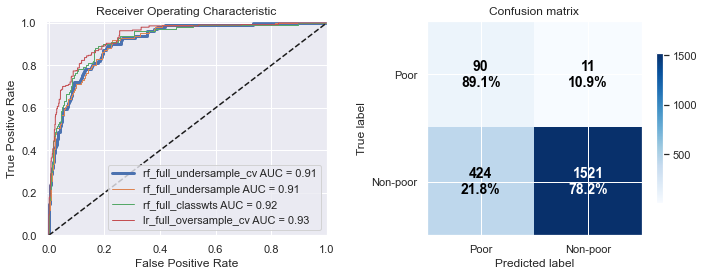

,rf_full_undersample_cv,rf_full_undersample,rf_full_classwts,lr_full_oversample_cv
accuracy,0.787390,0.801075,0.956012,0.940535
recall,0.891089,0.871287,0.227723,0.682982
precision,0.175097,0.182573,0.657143,0.526119
f1,0.292683,0.301887,0.338235,0.594375
cross_entropy,0.447345,0.449701,0.172160,0.282615
roc_auc,0.913467,0.913039,0.921143,0.932446
cohen_kappa,0.229069,0.239838,0.320983,0.501967


Actual poverty rate: 6.82% 
Predicted poverty rate: 26.71% 


In [14]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# build the model
estimator = RandomForestClassifier()
parameters = {'n_estimators': [10, 50, 100],
              'max_depth': np.arange(1,16,5), 
              'min_samples_split': np.arange(2,21,10),
              'min_samples_leaf': np.arange(1,46,20)
             }
model = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    compare_models=['rf_full_undersample', 
                                                    'rf_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)
best_model = model.best_estimator_

Cross validation for this model has only a minor impact on performance. As with Logistic Regression, we tend to get better recall using undersamping, but better overall performance using oversampling.

In [15]:
feat_imps.head(20)

,importance
r301,0.043973
der_nchild10under,0.034253
r303,0.024580
der_nliterate,0.019845
r304,0.017684
r2002,0.017249
kons_213,0.016827
r1808,0.016146
r1701,0.015258
r2001b,0.015079


## AdaBoost Random Forest Classifier 

X shape after undersampling:  (602, 506)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Wall time: 1.23 s
Wall time: 23 ms
In-sample score: 100.00%
Best model parameters: {'learning_rate': 0.01, 'n_estimators': 100}


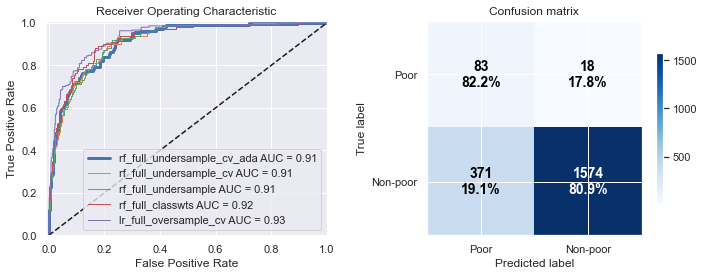

,rf_full_undersample_cv_ada,rf_full_undersample_cv,rf_full_undersample,rf_full_classwts,lr_full_oversample_cv
accuracy,0.809873,0.787390,0.801075,0.956012,0.940535
recall,0.821782,0.891089,0.871287,0.227723,0.682982
precision,0.182819,0.175097,0.182573,0.657143,0.526119
f1,0.299099,0.292683,0.301887,0.338235,0.594375
cross_entropy,0.432333,0.447345,0.449701,0.172160,0.282615
roc_auc,0.913991,0.913467,0.913039,0.921143,0.932446
cohen_kappa,0.237519,0.229069,0.239838,0.320983,0.501967


Actual poverty rate: 6.82% 
Predicted poverty rate: 24.64% 


In [16]:
from sklearn.ensemble import AdaBoostClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# build the model
estimator = AdaBoostClassifier(best_model)

parameters = {'n_estimators': [50, 100], 
              'learning_rate': [0.01, 0.1]
             }
model = GridSearchCV(estimator, parameters, verbose=3, cv=3, n_jobs=-1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    compare_models=['rf_full_undersample_cv',
                                                    'rf_full_undersample', 
                                                    'rf_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample_cv_ada', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)
best_model = model.best_estimator_

In [17]:
feat_imps.head(20)

,importance
r301,0.042055
der_nchild10under,0.028776
r303,0.020379
r1804,0.019942
kons_166,0.016315
r1701,0.016169
der_ninternetpast3mo,0.015275
r1702,0.014465
der_nliterate,0.014016
kons_214,0.013646


## Feature selection

X shape after feature selection:  (6136, 168)
X shape after undersampling:  (602, 168)
Wall time: 407 ms
Wall time: 39 ms
In-sample score: 100.00%


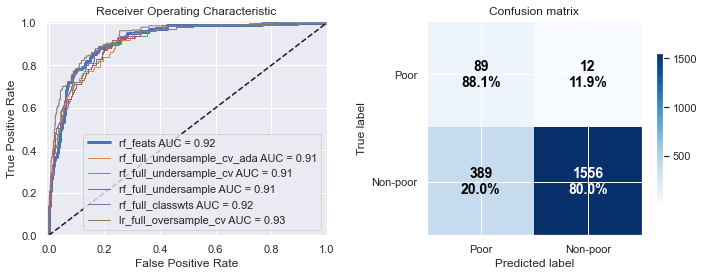

,rf_feats,rf_full_undersample_cv_ada,rf_full_undersample_cv,rf_full_undersample,rf_full_classwts,lr_full_oversample_cv
accuracy,0.804008,0.809873,0.787390,0.801075,0.956012,0.940535
recall,0.881188,0.821782,0.891089,0.871287,0.227723,0.682982
precision,0.186192,0.182819,0.175097,0.182573,0.657143,0.526119
f1,0.307427,0.299099,0.292683,0.301887,0.338235,0.594375
cross_entropy,0.425581,0.432333,0.447345,0.449701,0.172160,0.282615
roc_auc,0.919494,0.913991,0.913467,0.913039,0.921143,0.932446
cohen_kappa,0.245968,0.237519,0.229069,0.239838,0.320983,0.501967


Actual poverty rate: 6.82% 
Predicted poverty rate: 24.95% 


In [18]:
feats = feat_imps[feat_imps.cumsum() <= 0.80].dropna().index.values

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)
cols = X_train.columns
print("X shape after feature selection: ", X_train.shape)

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = best_model
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    compare_models=['rf_full_undersample_cv_ada', 
                                                    'rf_full_undersample_cv',
                                                    'rf_full_undersample', 
                                                    'rf_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='feats', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)

In [19]:
cons_feats = [x for x in feats if x[0:5] == 'kons_']
print("{} consumables features selected:".format(len(cons_feats)))
for x in cons_feats:
    print(x)

106 consumables features selected:
kons_166
kons_214
kons_107
kons_56
kons_229
kons_236
kons_268
kons_81
kons_277
kons_179
kons_283
kons_207
kons_278
kons_213
kons_224
kons_273
kons_91
kons_234
kons_78
kons_180
kons_34
kons_259
kons_160
kons_148
kons_264
kons_48
kons_162
kons_300
kons_6
kons_68
kons_26
kons_111
kons_282
kons_155
kons_165
kons_195
kons_301
kons_168
kons_138
kons_145
kons_82
kons_96
kons_258
kons_13
kons_131
kons_256
kons_170
kons_299
kons_176
kons_135
kons_95
kons_254
kons_238
kons_74
kons_163
kons_73
kons_129
kons_83
kons_266
kons_287
kons_257
kons_280
kons_216
kons_80
kons_261
kons_18
kons_184
kons_156
kons_103
kons_113
kons_157
kons_57
kons_147
kons_42
kons_141
kons_140
kons_243
kons_284
kons_164
kons_79
kons_30
kons_194
kons_253
kons_159
kons_33
kons_144
kons_84
kons_85
kons_136
kons_153
kons_93
kons_117
kons_175
kons_115
kons_154
kons_123
kons_271
kons_10
kons_251
kons_193
kons_76
kons_275
kons_21
kons_75
kons_269
kons_86


## Random Forest Riau Summary 

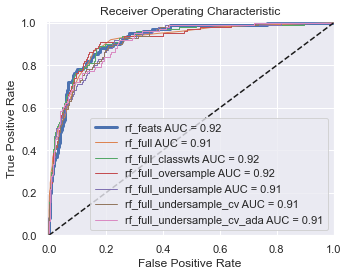

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
rf_feats,0.804008,0.881188,0.186192,0.307427,0.425581,0.919494,0.245968,0.181334
rf_full,0.952590,0.039604,1.000000,0.076190,0.145552,0.913816,0.072703,-0.014675
rf_full_classwts,0.956012,0.227723,0.657143,0.338235,0.172160,0.921143,0.320983,-0.007466
rf_full_oversample,0.915934,0.673267,0.328502,0.441558,0.378935,0.917188,0.401870,-0.003514
rf_full_undersample,0.801075,0.871287,0.182573,0.301887,0.449701,0.913039,0.239838,0.187081
rf_full_undersample_cv,0.787390,0.891089,0.175097,0.292683,0.447345,0.913467,0.229069,0.198927
rf_full_undersample_cv_ada,0.809873,0.821782,0.182819,0.299099,0.432333,0.913991,0.237519,0.178248


In [20]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)

## VS Logistic Regression

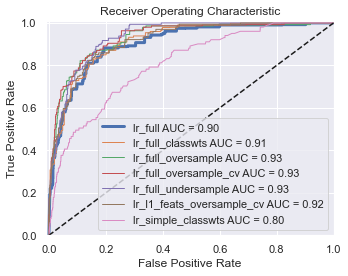

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
lr_full,0.930738,0.466875,0.457938,0.462363,1.327124,0.904081,0.363980,0.000409
lr_full_classwts,0.929499,0.479928,0.450620,0.464812,1.082523,0.914168,0.400154,0.004715
lr_full_oversample,0.933880,0.632532,0.485975,0.549652,0.364062,0.927669,0.452221,0.018465
lr_full_oversample_cv,0.940535,0.682982,0.526119,0.594375,0.282615,0.932446,0.501967,0.021896
lr_full_undersample,0.835955,0.889434,0.265465,0.408891,0.634811,0.933625,0.320408,0.154480
lr_l1_feats_oversample_cv,0.854298,0.823472,0.280952,0.418963,0.364059,0.915807,0.346496,0.124128
lr_simple_classwts,0.732649,0.702970,0.120748,0.206096,0.537430,0.804167,0.133050,0.341761


In [21]:
evaluation.compare_algorithm_models('lr', COUNTRY)